# Sun-Earth Tidal Interaction
## 4 Myr Pre-TRGB

### Parameter Interpolation

If parameters are changing significantly on dynamical timescales (e.g. mass transfer at pericenter on very eccentric orbits) you need a specialized numerical scheme to do that accurately.
However, there are many astrophysical settings where parameters change very slowly compared to all the dynamical timescales in the problem.
As long as this is the case and the changes are adiabatic, you can modify these parameters between calls to `sim.integrate` very flexibly and without loss of accuracy. 

In order to provide a machine-independent way to interpolate parameters at arbitrary times, which can be shared between the C and Python versions of the code, we have implemented an interpolator object. 
For example, say you want to interpolate stellar evolution data.
We show below how you can use the `Interpolator` structure to spline a discrete set of time-parameter values.

We begin by reading in mass and radius data of our Sun, starting roughly 4 million years before the tip of its red-giant branch (RGB), and separating them into time and value arrays. 
You can populate these arrays however you want, but we load two text files (one for stellar mass, the other for stellar radius), where the first column gives the time (e.g., the Sun's age), and the second column gives the corresponding value (mass or radius).

All values need to be in simulation units. If you're using AU, then your stellar radii should also be in AU.

#### Tidal Parameters
The convective friction time is

\begin{equation}
t_f = \left(\dfrac{MR^2}{L}\right)^{1/3}.
\tag{1}
\end{equation}

We precaculate the values of $t_f(t)$ for the Sun's evolution, as all the parameters are already known in advance. Offloading this calculation before the simulation's start helps reduce extra math operations in between timesteps.

Our expression for Hut's constant time lag is

\begin{equation}
\tau = \dfrac{2R^3r}{GMt_f}.
\tag{2}
\end{equation}

Similarly, we can precalculate the known values of $\tau$ (all except for $r$) into its own "prefactor."

In [1]:
import numpy as np

data = np.loadtxt('mesa2txt/m.txt') # return (N, 2) array
mtimes = data[:, 0]                 # return only 1st col
masses = data[:, 1]                 # return only 2nd col

data = np.loadtxt('mesa2txt/r.txt')
rtimes = data[:, 0]
Rsuns = data[:, 1]                  # data in Rsun units

data = np.loadtxt('mesa2txt/l.txt')
ltimes = data[:, 0]
Lsuns = data[:, 1]                  # data in Lsun units

radii = np.zeros(Rsuns.size)        # convert Rsun to AU
for i, r in enumerate(Rsuns):
    radii[i] = r * 0.00465047       # 215 Rsun ~ 1 AU
    radii[i] += 0.15                # upshift to match Schroder
    
watts = np.zeros(Lsuns.size)        # convert Lsun to W (MKS units)
for i, l in enumerate(Lsuns):
    watts[i] = l * 3.828e26         # IAU Resolution B3 conversion

lumins = np.zeros(watts.size)       # convert W to sim units
for i, w in enumerate(watts):
    lumins[i] = (w * ((6.7e-12)**2) * (5e-31)) / ((3.2e-8)**3)

t_fs = np.zeros(lumins.size)        # precalculate t_f (Eq. 1)
for i, l in enumerate(lumins):
    t_fs[i] = np.cbrt(masses[i]*radii[i]**2/l)
    
pretaus = np.zeros(t_fs.size)       # precalc pretau (Eq. 2)
G = 4*np.pi**2                      # units of AU, yrs and solar masses
for i, t_f in enumerate(t_fs):
    pretaus[i] = 2.*radii[i]**3/G/masses[i]/t_f

Next we set up the Sun-Earth system.

In [2]:
import rebound
import reboundx

M0 = 0.8646552426064663 # initial mass of star

def makesim():
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')
    sim.add(m=M0, hash='Sun')
    sim.add(m=3.e-6, a=1., hash='Earth')
    sim.add(a=10., hash='Hidden')
    sim.dt = 0.1*sim.particles[1].P
    sim.move_to_com()
    rebx = reboundx.Extras(sim)
    tides = rebx.load_force("tides_constant_time_lag")
    rebx.add_force(tides)
    return sim, rebx, tides

Now we can create an `Interpolator` object for each parameter set and pass the corresponding arrays as arguments.

In [3]:
# initialize sim and create Interpolator objects
sim, rebx, tides = makesim()
starmass = reboundx.Interpolator(rebx, mtimes, masses, 'spline')
starradius = reboundx.Interpolator(rebx, rtimes, radii, 'spline')
starptau = reboundx.Interpolator(rebx, ltimes, pretaus, 'spline')

# update Sun's mass and radius accordingly
ps = sim.particles
T0 = 1.23895e10 # Sun's age ~ 4 Myr pre-TRGB (sim start)
ps[0].m = starmass.interpolate(rebx, t=T0)
ps[0].r = starradius.interpolate(rebx, t=T0)
sim.move_to_com()

In [4]:
print('M0 =', starmass.interpolate(rebx, t=T0), 'Msun')
print('R0 =', starradius.interpolate(rebx, t=T0), 'Rsun')
print('tau0 =', starptau.interpolate(rebx, t=T0), 'yr')

M0 = 0.8646552426064663 Msun
R0 = 0.5331331894181437 Rsun
tau0 = 0.008659012813615877 yr


### Tides Constant Time Lag

We specify the primary and secondaries' equilibrium gravitational response to the tidal field acting on them through the `tctl_k1` apsidal motion constant, equal to half the tidal Love number $k_2$. According to Zahn (1989), $\lambda_2 \approx k_1$.

If we give the primary a physical radius, then any (massive) orbiting body will raise equilibrium tides on the primary.

In [5]:
ps[0].params["tctl_k1"] = 0.038 # ~ lambda_2, Schroder & Smith (2008)

If we additionally set the `tctl_tau` constant time lag parameter, this delayed response introduces dissipation, which will typically cause eccentricity damping, and will migrate the orbiting bodies either inward or outward depending on whether they orbit faster or slower than the spin of the tidally deformed body. We set the spin rate of each body with the `Omega` parameter. If it is not set, `Omega` is assumed to be zero.

We note that this implementation assumes bodies' spins are fixed, so consider whether more angular momentum is being changed in the system than is available in the spins! We additionally assume that bodies spins are aligned with the reference z axis.

In [6]:
ps[0].params["tctl_tau"] = starptau.interpolate(rebx, t=T0)
ps[0].params["Omega"] = 0 # explicitly set to 0 (would be 0 by default)

Finally, we integrate for 4 Myr, updating the central body's mass and radius interpolated at the time between outputs. We then plot the resulting system:

In [7]:
%%time
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros(Nout)
ts = np.linspace(0., 4.e6, Nout)

for i, time in enumerate(ts):
    sim.integrate(time)
    d = ps[0] - ps[1] # componentwise difference between particles
    r = np.sqrt(d.x**2 + d.y**2 + d.z**2)
            
    # evolve Sun and recenter to COM
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t)
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com()
    
    # record for post-sim plots
    mass[i] = sim.particles[0].m
    radius[i] = sim.particles[0].r
    a[i] = sim.particles[1].a
    
    if r <= ps[0].r:              # nearest planet engulfed
        break
    
    # update tidal parameter
    ps[0].params["tctl_tau"] = starptau.interpolate(rebx, t=T0+sim.t)*r # Eq. 2

CPU times: user 20min 58s, sys: 1min 17s, total: 22min 16s
Wall time: 22min 19s


We see that, as the Sun loses mass along its RGB phase, the Earth has correspondingly and adiabatically expanded, as one might expect. Let's now plot the Sun's mass over time, and a comparison of the Sun's radius and Earth's semi-major axis over time, adjacent to one another.

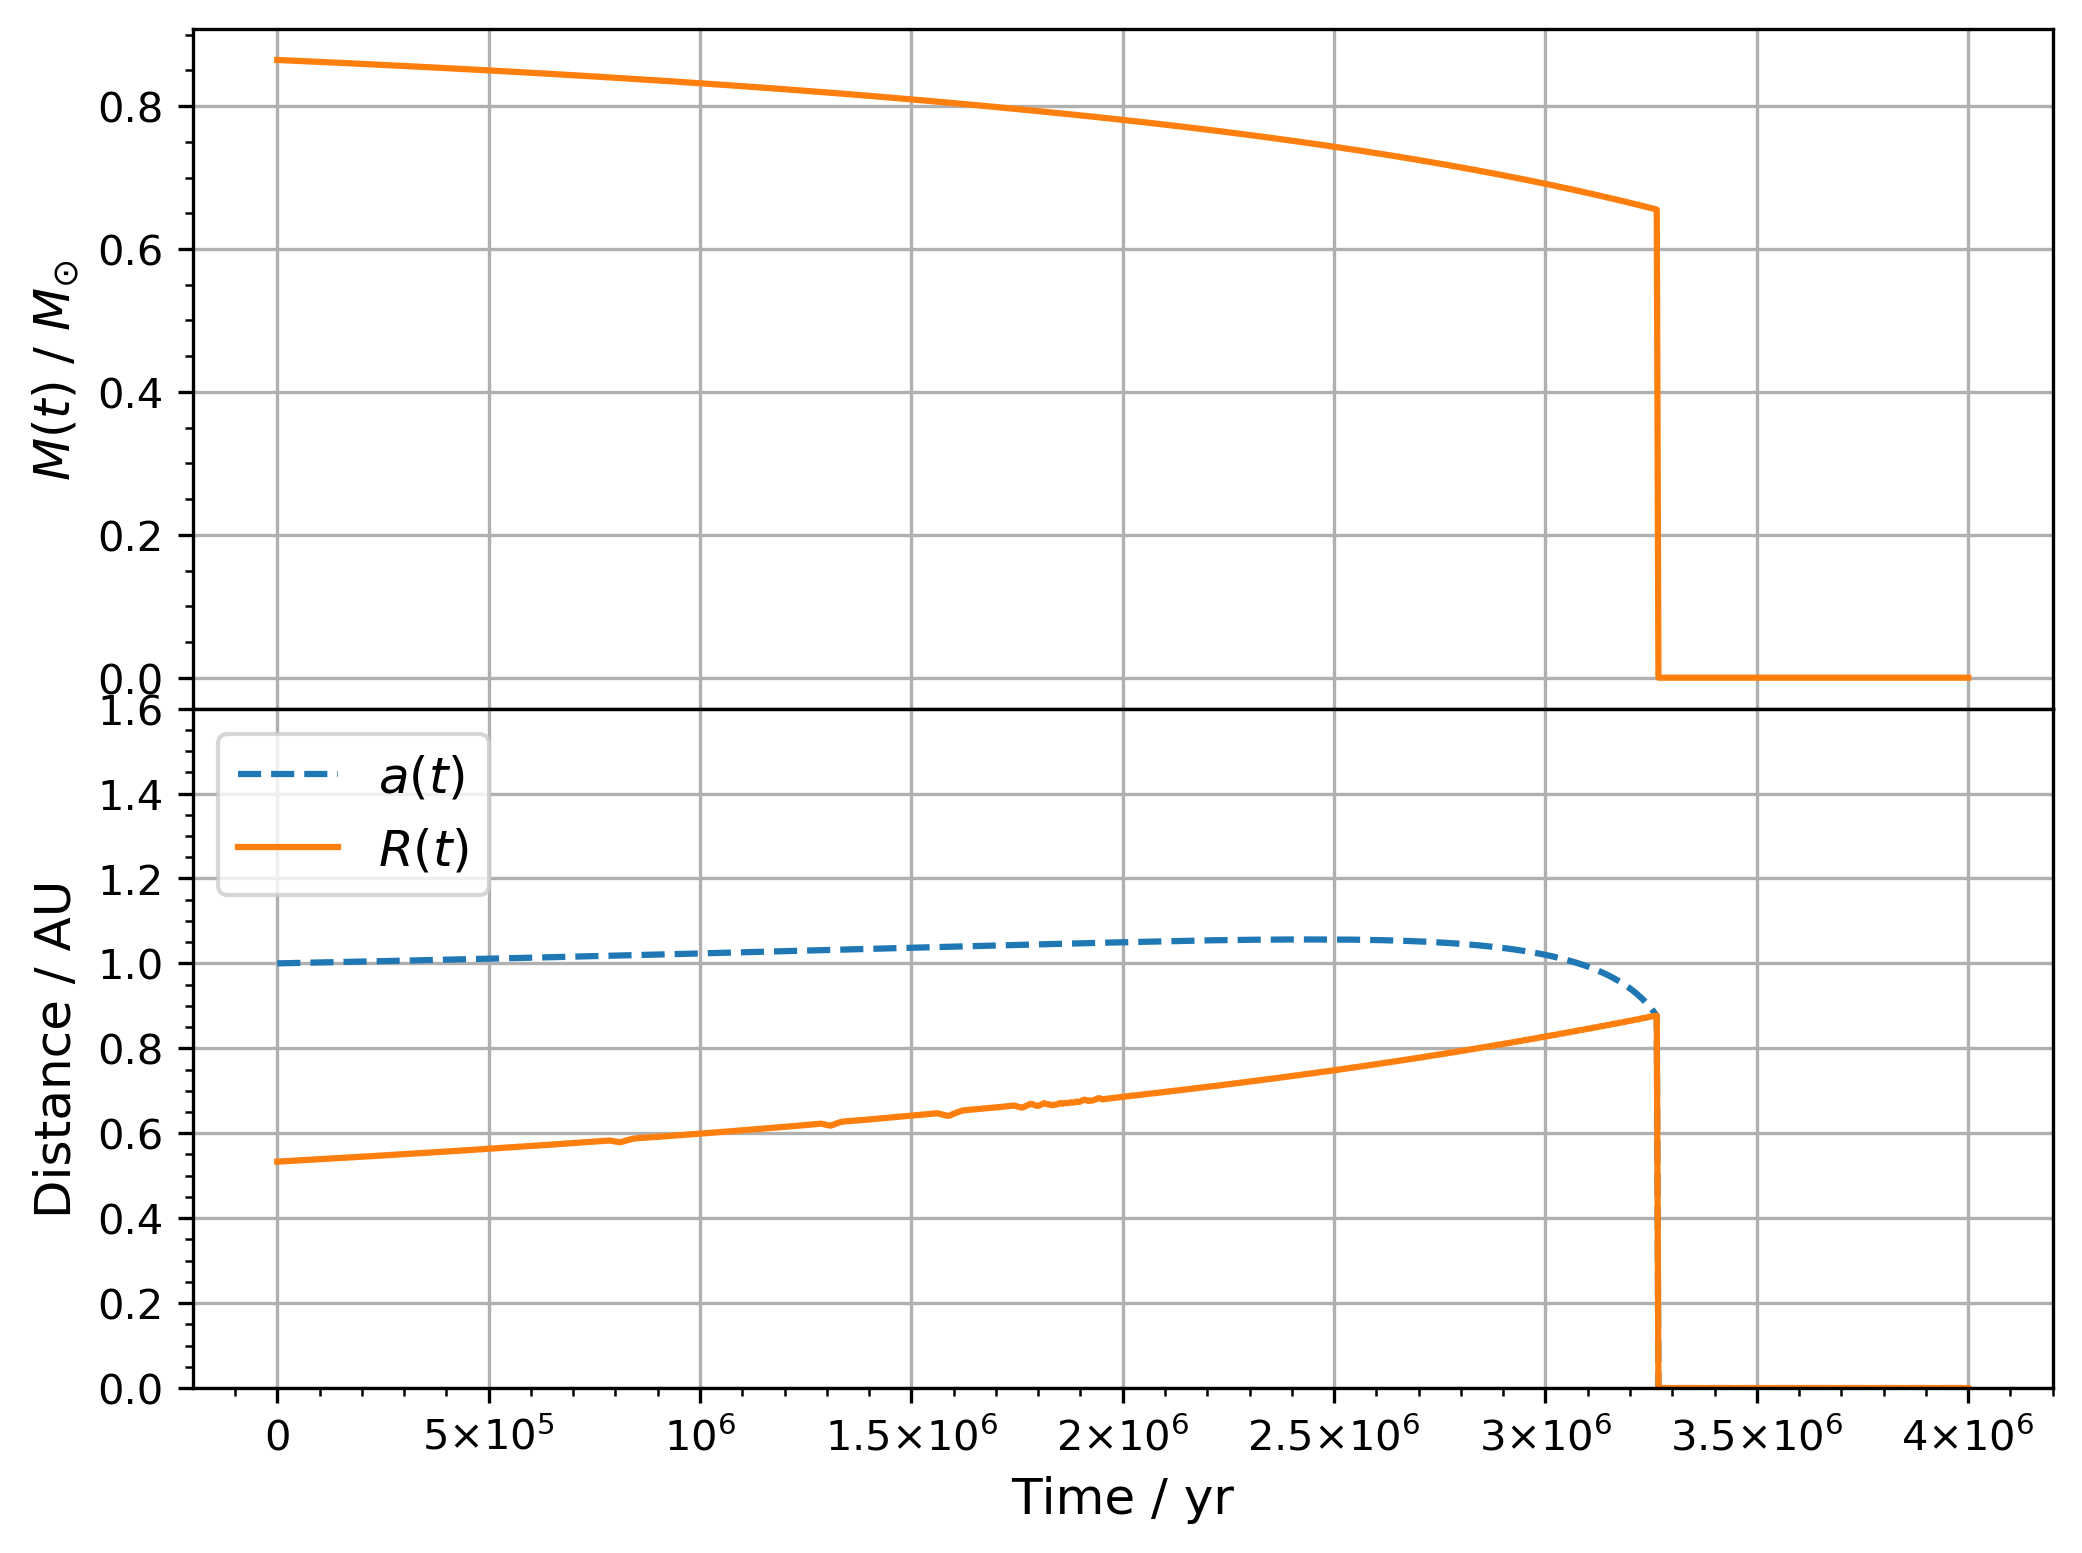

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6), dpi=300)
fig.subplots_adjust(hspace=0)

ax1.set_ylabel("$M(t)$ / $M_{\odot}$", fontsize='large')
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.plot(ts,mass, color='tab:orange')
ax1.grid()

ax2.set_xlabel('Time / yr', fontsize='large')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.set_ylabel('Distance / AU', fontsize='large')
ax2.set_ylim([0, 1.6])
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.plot(ts,a, '--', label='$a(t)$')
ax2.plot(ts,radius, label='$R(t)$')
ax2.legend(fontsize='large', loc='upper left')
ax2.grid()

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.savefig('plots/expansion_tides.png')